# fii merge csvs notebook

Objective

FII Data has been moved from XLSX to csv format, now load it all into a single table and take a look

 
Data selection
 * choosing to ignore data other than Uganda and Tanzania and Nigeria and Kenya
 * Using Wave 3 surveys only
 * limiting columns to those selected for analysis.  See notebook "Columns for analysis"


In [1]:
!head columns_for_analysis



Questions retained for analysis

 Set 1 Basic demographics
 Set 2 Mobile and Mobile money usage
 Set 3 Retention (longitudinal) 


Wave 3


In [2]:
import os
import pandas as pd
import numpy as np

source_data_dir = 'Data/fii_csv/'

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


/home/aman/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
csv_files = os.listdir(source_data_dir)

# We only care about these countries right now right now
keep_countries = ['uganda', 'tanzania', 'nigeria', 'kenya']
csv_files = [f for f in csv_files
             if any([country in f for country in keep_countries])
            ]

# keep wave 3 only
csv_files = [f for f in csv_files if 'w3' in f]

csv_files

['fsp_final_nigeria_w3_(public).csv',
 'fsp_final_kenya_w3_(public).csv',
 'fsp_final_tanzania_w3_(public).csv',
 'fsp_final_uganda_w3_(public).csv']

In [4]:
import re

def get_country_from_filename(filename):
    """utility function to extract the country name from the filename"""
    spl = re.split('[_ -]', filename)
    idx = spl.index('final') + 1
    return spl[idx]

# test
print "Test\n{} --> {}".format(
    'fsp_final_uganda_w3_(public).csv',
    get_country_from_filename('fsp_final_uganda_w3_(public).csv')
    )

Test
fsp_final_uganda_w3_(public).csv --> uganda


In [5]:
all_dfs = []
for csv_file in csv_files:
    path = os.path.join(source_data_dir, csv_file)
    print "Loading {}.".format(path)
    
    df = pd.read_table(path, 
                       sep=',',
                      )
    
    df['country'] = get_country_from_filename(csv_file)
    df['source_filename'] = csv_file
    
    # consistent capitalization across all columns
    cols_load = df.columns.tolist()
    cols_renamed = [c.lower() for c in cols_load]
    df = df.rename(columns=dict(zip(cols_load, cols_renamed)))
    
    all_dfs.append(df)

print "Done loading {} files.".format(len(all_dfs))

Loading Data/fii_csv/fsp_final_nigeria_w3_(public).csv.
Loading Data/fii_csv/fsp_final_kenya_w3_(public).csv.
Loading Data/fii_csv/fsp_final_tanzania_w3_(public).csv.
Loading Data/fii_csv/fsp_final_uganda_w3_(public).csv.

/home/aman/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (873) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/aman/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (828) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Done loading 4 files.


### Attempting cleanup

In [6]:
#Check shapes of each little dataframe
for df in all_dfs:
    print "{:<50} : {}".format(df.source_filename[0], df.shape)

fsp_final_nigeria_w3_(public).csv                  : (6001, 1033)
fsp_final_kenya_w3_(public).csv                    : (2994, 1090)
fsp_final_tanzania_w3_(public).csv                 : (3001, 983)
fsp_final_uganda_w3_(public).csv                   : (3000, 998)


In [7]:
# if we just merge all these directly, we get: 
big_df = pd.concat(all_dfs)
print big_df.shape
del big_df

(14996, 1185)


# Columns

In [8]:
print "Columns"

cols_array = [df.columns.tolist() for df in all_dfs]

print "{:<15} : {}".format(
    "Intersection / And",
    len(set.intersection(*map(set,cols_array)))
    )

print "{:15} : {}".format(
    "Disjoint / difference",
    len(set.difference(*map(set,cols_array)))
    )

print "{:15} : {}".format(
    "Union / OR", 
    len(set.union(*map(set,cols_array)))
    )

all_columns_union = set.union(*map(set,cols_array))

Columns
Intersection / And : 939
Disjoint / difference : 64
Union / OR      : 1185


In [9]:
code_book_dict = {
    # Taken from ffi codebook by manual inspection 
    # see 'columns for analysis'
    # 
    # Custom
    'source_filename': 'source_filename',
    'country': 'country',
    
    # Set 1
    # ----------------
    'DG1'  : 'year_of_birth',
    'DG2'  : 'gender',
    'DG3'  : 'marital_status',
    'DG4'  : 'education_level',
    
    
    # Set 2
    # ----------------
    'MM1'  : 'heard_of_mobile_money',
    
    #'MM4'  : 'ever_used_any_mobile_money_service',
    'MM4_1'  : 'ever_used_any_mobile_money_service|serv1',
    'MM4_2'  : 'ever_used_any_mobile_money_service|serv2',
    'MM4_3'  : 'ever_used_any_mobile_money_service|serv3',
    'MM4_4'  : 'ever_used_any_mobile_money_service|serv4',
    'MM4_5'  : 'ever_used_any_mobile_money_service|serv5',
    'MM4_6'  : 'ever_used_any_mobile_money_service|serv6',
    'MM4_7'  : 'ever_used_any_mobile_money_service|serv7',
    'MM4_8'  : 'ever_used_any_mobile_money_service|serv8',
    'MM4_9'  : 'ever_used_any_mobile_money_service|serv9',
    'MM4_10'  : 'ever_used_any_mobile_money_service|serv10',
    'MM4_11'  : 'ever_used_any_mobile_money_service|serv11',
    'MM4_12'  : 'ever_used_any_mobile_money_service|serv12',
    'MM4_13'  : 'ever_used_any_mobile_money_service|serv13',
    'MM4_14'  : 'ever_used_any_mobile_money_service|serv14',
    
    #'MM6'  : 'have_account_with_any_mobile_money_service',
    'MM6_1'  : 'have_account_with_any_mobile_money_service|serv1',
    'MM6_2'  : 'have_account_with_any_mobile_money_service|serv2',
    'MM6_3'  : 'have_account_with_any_mobile_money_service|serv3',
    'MM6_4'  : 'have_account_with_any_mobile_money_service|serv4',
    'MM6_5'  : 'have_account_with_any_mobile_money_service|serv5',
    'MM6_6'  : 'have_account_with_any_mobile_money_service|serv6',
    'MM6_7'  : 'have_account_with_any_mobile_money_service|serv7',
    'MM6_8'  : 'have_account_with_any_mobile_money_service|serv8',
    'MM6_9'  : 'have_account_with_any_mobile_money_service|serv9',
    'MM6_10'  : 'have_account_with_any_mobile_money_service|serv10',
    'MM6_11'  : 'have_account_with_any_mobile_money_service|serv11',
    'MM6_12'  : 'have_account_with_any_mobile_money_service|serv12',
    'MM6_13'  : 'have_account_with_any_mobile_money_service|serv13',
    'MM6_14'  : 'have_account_with_any_mobile_money_service|serv14',
    
    'MM10' : 'biggest_challenge_with_mobile_money',
    'MM12' : 'reason_never_used_mobile_money',
    
    #'MM15' : 'ever_used_mobile_money_for_this_activity',
    'MM15_1' : 'ever_used_mobile_money_for|deposit',
    'MM15_2' : 'ever_used_mobile_money_for|withdraw',
    'MM15_3' : 'ever_used_mobile_money_for|paymobilebill',
    'MM15_4' : 'ever_used_mobile_money_for|payschoolfee',
    'MM15_5' : 'ever_used_mobile_money_for|paymedical',
    'MM15_6' : 'ever_used_mobile_money_for|payelectrical',
    'MM15_7' : 'ever_used_mobile_money_for|paywater',
    'MM15_8' : 'ever_used_mobile_money_for|paysolar',
    'MM15_9' : 'ever_used_mobile_money_for|paytv',
    'MM15_10' : 'ever_used_mobile_money_for|paygovt',
    'MM15_11' : 'ever_used_mobile_money_for|sendmoneyindiv',
    'MM15_12' : 'ever_used_mobile_money_for|getmoneyindiv',
    'MM15_13' : 'ever_used_mobile_money_for|getmoneygovt',
    'MM15_14' : 'ever_used_mobile_money_for|getwages',
    'MM15_15' : 'ever_used_mobile_money_for|paylarge',
    'MM15_16' : 'ever_used_mobile_money_for|payinsurance',
    'MM15_17' : 'ever_used_mobile_money_for|payloan',
    'MM15_18' : 'ever_used_mobile_money_for|savemoney',
    'MM15_19' : 'ever_used_mobile_money_for|setasidepension',
    'MM15_20' : 'ever_used_mobile_money_for|setasideother',
    'MM15_21' : 'ever_used_mobile_money_for|makeinvestment',
    'MM15_22' : 'ever_used_mobile_money_for|payatstore',
    'MM15_23' : 'ever_used_mobile_money_for|transfermobile',
    'MM15_24' : 'ever_used_mobile_money_for|transferbank',
    'MM15_25' : 'ever_used_mobile_money_for|transfermobiletoother',
    'MM15_26' : 'ever_used_mobile_money_for|lendinggroup',
    'MM15_27' : 'ever_used_mobile_money_for|payrent',
    'MM15_28' : 'ever_used_mobile_money_for|accountmaint',
    'MM15_29' : 'ever_used_mobile_money_for|other',
    
    # Set 3
    # ----------------
    
    #'MM5'  : 'last_time_financial_activity_with_mobile_money',
    'MM5_1' : 'last_time_fin_activity_w_mobile_money|yesterday',
    'MM5_2' : 'last_time_fin_activity_w_mobile_money|past7days',
    'MM5_3' : 'last_time_fin_activity_w_mobile_money|past30days',
    'MM5_4' : 'last_time_fin_activity_w_mobile_money|past90days',
    'MM5_5' : 'last_time_fin_activity_w_mobile_money|morethan90days',
    
    #'MM8'  : 'last_time_financial_activity_using_account',
    'MM8_1'  : 'last_time_financial_activity_using_account|serv1',
    'MM8_2'  : 'last_time_financial_activity_using_account|serv2',
    'MM8_3'  : 'last_time_financial_activity_using_account|serv3',
    'MM8_4'  : 'last_time_financial_activity_using_account|serv4',
    'MM8_5'  : 'last_time_financial_activity_using_account|serv5',
    'MM8_6'  : 'last_time_financial_activity_using_account|serv6',
    'MM8_7'  : 'last_time_financial_activity_using_account|serv7',
    'MM8_8'  : 'last_time_financial_activity_using_account|serv8',
    'MM8_9'  : 'last_time_financial_activity_using_account|serv9',
    'MM8_10'  : 'last_time_financial_activity_using_account|serv10',
    'MM8_11'  : 'last_time_financial_activity_using_account|serv11',
    'MM8_12'  : 'last_time_financial_activity_using_account|serv12',
    'MM8_13'  : 'last_time_financial_activity_using_account|serv13',
    'MM8_14'  : 'last_time_financial_activity_using_account|serv14',
    
    #'MM17' : 'how_often_use_mobile_money_for_this_activity',
    'MM17_1' : 'last_time_activity_on_phone|yesterday',
    'MM17_2' : 'last_time_activity_on_phone|past7days',
    'MM17_3' : 'last_time_activity_on_phone|past30days',
    'MM17_4' : 'last_time_activity_on_phone|past90days',
    'MM17_5' : 'last_time_activity_on_phone|morethan90days',
    'MM17_6' : 'last_time_activity_on_phone|never',
    
    'MM9'  : 'how_long_using_mobile_money',
    
    # IFI1
    # IFI2
    # IFI3
    # IFI4
    # IFI10
    # IFI11
    # IFI12
    # IFI13    
}

# make all lower case
code_book_dict = {k.lower(): v for k, v in code_book_dict.items()}

"""
These are human readable columns in all dataframes
Found by printing column names intersection
>>> set.intersection(*map(set,cols_array))
and filtering manually
"""
human_readable_columns = [
    'access_bank_full',
    'access_mm',
    'access_mm_and_bank_full',
    'access_mm_or_bank_full',
    'access_phone',
    'access_phone_sim',
    'active_bank_full',
    'active_mm',
    'active_mm_and_bank_full',
    'active_mm_or_bank_full',
    'active_nonreg_mm',
    'age',
    'age_group',
    'aware_mm',
    'aware_mm_provider',
    'business_bank',
    'business_bank_and_mm',
    'business_bank_or_mm',
    'business_mm',
    'lapsed_nonreg_mm',
    'lapsed_registered_mm',
    'literacy',
    'nonregistered_bank_full',
    'nonregistered_mm',
    'nonregistered_mm_and_bank_full',
    'nonregistered_mm_or_bank_full',
    'nonuser_bank_full',
    'nonuser_mm',
    'nonuser_mm_bank_full',
    'numeracy',
    'own_phone_sim',
    'ppi_cutoff',
    'ppi_score',
    'registered_bank_full',
    'registered_mm',
    'registered_mm_and_bank_full',
    'registered_mm_or_bank_full',
    'rural_females',
    'rural_males',
    'rural_poor',
    'ur',
    'weight'
]

In [10]:
# from codebook
keep_cols = list(code_book_dict.viewkeys())

# from human readable list
# I DO NOT TRUST THESE "human readable columns" #AA 20160910
# keep_cols = keep_cols + human_readable_columns

print "Keeping these columns: ", keep_cols

print "\nWarning!",
print "These columns not found in all dfs:"
for col in sorted(keep_cols):
    if not all([col in idf.columns.tolist() for idf in all_dfs]):
        print col



Keeping these columns:  ['mm5_5', 'mm5_4', 'mm5_3', 'mm5_2', 'mm5_1', 'mm4_10', 'mm4_11', 'mm4_12', 'mm4_13', 'mm4_14', 'mm6_12', 'mm6_13', 'mm6_10', 'mm6_11', 'mm6_14', 'mm17_5', 'mm17_4', 'mm17_6', 'mm17_1', 'mm17_3', 'mm17_2', 'mm1', 'mm15_22', 'mm15_23', 'mm15_20', 'mm15_21', 'mm15_26', 'mm15_27', 'mm15_24', 'mm15_25', 'mm15_28', 'mm15_29', 'country', 'mm15_3', 'mm15_2', 'mm15_1', 'mm15_7', 'mm15_6', 'mm15_5', 'mm15_4', 'mm15_9', 'mm15_8', 'mm8_2', 'mm8_3', 'mm8_1', 'mm8_6', 'mm8_7', 'mm8_4', 'mm8_5', 'mm9', 'mm8_8', 'mm8_9', 'mm6_1', 'mm6_2', 'mm6_3', 'mm6_4', 'mm6_5', 'mm6_6', 'mm6_7', 'mm6_8', 'mm6_9', 'mm4_6', 'mm4_7', 'mm4_4', 'mm4_5', 'mm4_2', 'mm4_3', 'mm4_1', 'mm4_8', 'mm4_9', 'source_filename', 'mm10', 'mm12', 'dg2', 'dg3', 'dg1', 'dg4', 'mm8_14', 'mm8_10', 'mm8_11', 'mm8_12', 'mm8_13', 'mm15_19', 'mm15_18', 'mm15_13', 'mm15_12', 'mm15_11', 'mm15_10', 'mm15_17', 'mm15_16', 'mm15_15', 'mm15_14']

Warning! These columns not found in all dfs:
mm4_10
mm4_11
mm4_12
mm4_13
mm4_1

In [11]:
# sanity check col names
# should return nothing
for col in keep_cols:
    if not col in all_dfs[0].columns.tolist():
        print col

In [12]:
# search in df columns
search_string = 'age'
for idf in all_dfs:
    #print idf.columns.tolist()
    print [c for c in idf.columns.tolist() if search_string in c.lower()]
    

['age', 'age_group']
['age', 'age_group']
['age', 'age_group']
['age', 'age_group']


# DO the work here

 * Here we construct the dataframe, finally
 * combine dataframes for each csv
 * keep only the columns specified above
 * dump to csv
 


In [13]:
# only keep columns we care about in each df
# must do this before merging df due to memory constraints

def drop_extra_cols(df, keep_cols):
    
    df_cols = df.columns.tolist()
    intersect_cols = set(df_cols).intersection(keep_cols)
    
    return df[list(intersect_cols)]

# drop columns in each dataframe
all_dfs_dropped_cols = [drop_extra_cols(df, keep_cols) for df in all_dfs]

# concatenate all dataframes into one
big_df = pd.concat(all_dfs_dropped_cols)

# rename columns from codebook
big_df = big_df.rename(columns=code_book_dict)


print big_df.shape

(14996, 92)


In [14]:
## dump to csv

big_df.to_csv('merged_fii_data_wave3_20160910.csv', )

In [15]:
big_df.country.value_counts()

nigeria     6001
tanzania    3001
uganda      3000
kenya       2994
Name: country, dtype: int64

In [16]:
big_df['country'].unique()

array(['nigeria', 'kenya', 'tanzania', 'uganda'], dtype=object)

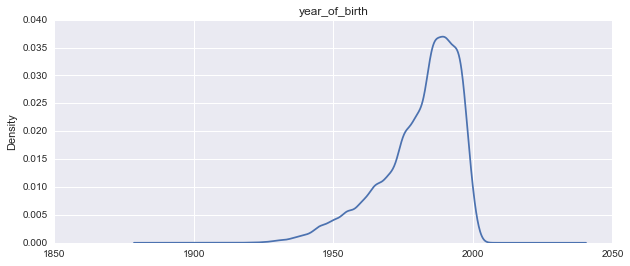

In [20]:
# quick test
col='year_of_birth'
ax = big_df[col].plot(kind='kde', title=col, figsize=(10,4))

In [21]:
import ipywidgets

In [22]:

select_column = ipywidgets.Select(
    options=sorted(list(big_df.columns.tolist())),
    description = "Select a column.")

select_column

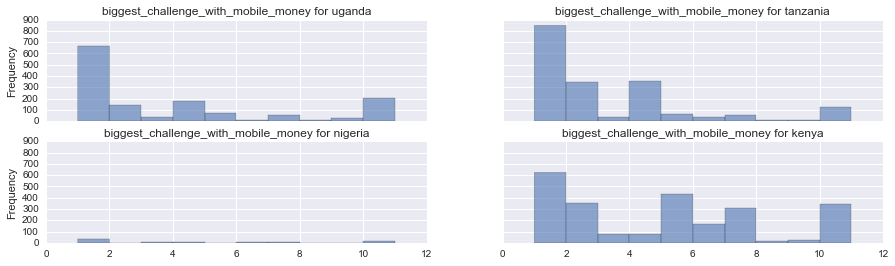

In [23]:
column = select_column.value

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,4), 
                         sharex=True, 
                         sharey=True
                        )
axlist = axes.flatten()

for idx, country in enumerate(keep_countries):
    ax = axlist[idx]
    mask = (big_df.country == country)
    if mask.sum() > 1:
        big_df[mask][column]\
            .plot(
                kind='hist', 
                title='{} for {}'.format(column, country),
                alpha=0.6,
                ax=ax,
            )
        #ax.set_xlim(0,100)
            